## Vgg16 modified connected with classifiers

The objective of this notebook, is classify the dataset of animals_10, using the vgg16 as feature extractor, connected with some models of classification, like SVM, RF, KNN

This dataset is avaible in the link :
https://www.kaggle.com/datasets/alessiocorrado99/animals10

Lets go to start the libraries that we can use for this.


In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
import os

from torch.optim import lr_scheduler
import numpy as np
import torchvision
import matplotlib.pyplot as plt

from torchvision import datasets, models, transforms
from sklearn.svm import LinearSVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import confusion_matrix

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

Many partes of scripts manipulations executed, can be finded as modules, performed to facility the uses in jupyter notebook

In [2]:
from preprocess_datast import PreprocessDataset
from estimate_metrics import MetricsAnaliser
from extract_features import ExtractFeaturesCnn

In some cases, when we works with datasets, it is convenient separate a single folder with images, im many directories.
It is necessary to use one part in train period, and the another as validation os test period

In [3]:
path_to_dataset = './dataset/raw-img/'
path_to_save = './dataset_animals/'

preprocess = PreprocessDataset()
preprocess.create_default_dataset(path_to_dataset, path_to_save)

Copying files: 26179 files [00:22, 1149.89 files/s]


Our dataset have random names, and in some cases, had big paths of directories. For convenience, lets rename the images in the subfoders, with the names of your respective class. 

This can help us to know what is the class of image, withou open and visualize the images.

In [4]:
preprocess.rename_images_with_labels(path_to_dataset)

Dataset Images Was Renamed


Now, we can use the transforms.Compose to easily load the entire dataset, and aply methods of data augmentation

In [5]:
extract_features = ExtractFeaturesCnn()

In [6]:
data_transforms = extract_features.aplly_transformation()

With dataloaders, is possible to finally extract the features of the images, with a model of CNN

In [7]:
dataloaders, inputs, classes_names = extract_features.prepare_dataloders('./dataset_animals/', data_transforms)

Here, we created a custom model. 

The method load_custom_vgg16, retur two models of CNN.

The first model is a model modified, when we remove the last two layers of model, where is the "Fully-Connected 2 (4096 features)"

The second model is the ori original vgg16, loaded just for visually comparation

In [8]:
custom_model, original_model = extract_features.load_custom_vgg16()

/home/dev_machine/.cache/pypoetry/virtualenvs/pattern_recognition-q6SkOk2A-py3.10/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/dev_machine/.cache/pypoetry/virtualenvs/pattern_recognition-q6SkOk2A-py3.10/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [9]:
custom_model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [10]:
original_model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

Now, the features of the dataset of train and test can be extracted

In [11]:
features_of_test = extract_features.extract_features_from_cnn('test', model=custom_model, dataloaders=dataloaders)
test_feature = features_of_test[0]
test_label = features_of_test[1]

features_of_train = extract_features.extract_features_from_cnn('train', model=custom_model, dataloaders=dataloaders)
train_feature = features_of_train[0]
train_label = features_of_train[1]

100%|███████████████| 4908/4908 [45:08<00:00,  1.81it/s]


With the features extracted, the classifiers are utilized to classify the classes. 

In this tests, we will use: 

* SVM (Suport Vector Machine), 
* RF (Random Florest), 
* KNN (K — Nearest Neighbors)

In [14]:
SVM = SVC()
RF = RandomForestClassifier()
KNN = KNeighborsClassifier()

In [15]:
classifier_SVM = SVM.fit(train_feature, train_label)
classifier_RF = RF.fit(train_feature, train_label)
classificer_KNN = KNN.fit(train_feature, train_label)

In [17]:
y_pred_svm = classifier_SVM.predict(test_feature)

y_pred_rf = classifier_RF.predict(test_feature)

y_pred_knn = classificer_KNN.predict(test_feature)

In [18]:
results_pred = [y_pred_svm, y_pred_rf, y_pred_knn]

Finally, the results of each classifier.

We can apreciate the results using a convolutional neural network. 
Each class of dataset has great metrics, very upper than Bag of Visual Words.


Results in SVM: 

Accuracy: 0.9589187538179597
F1-Score: 0.9555288564719907
Precision: 0.9598567426159643
Recall: 0.9515592979313008

Results in RF: 

Accuracy: 0.9441050702504582
F1-Score: 0.9394352199888341
Precision: 0.9479594316832213
Recall: 0.9322114653841476

Results in KNN: 

Accuracy: 0.9219609040928528
F1-Score: 0.9148899716639978
Precision: 0.923366528435065
Recall: 0.9079185887652104


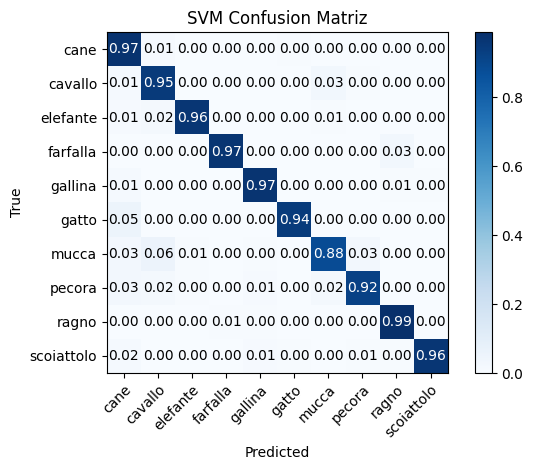

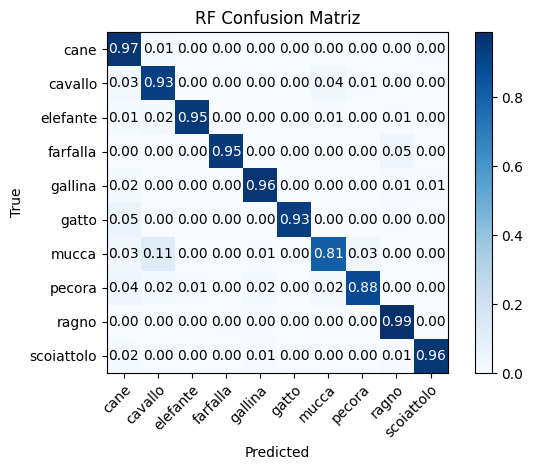

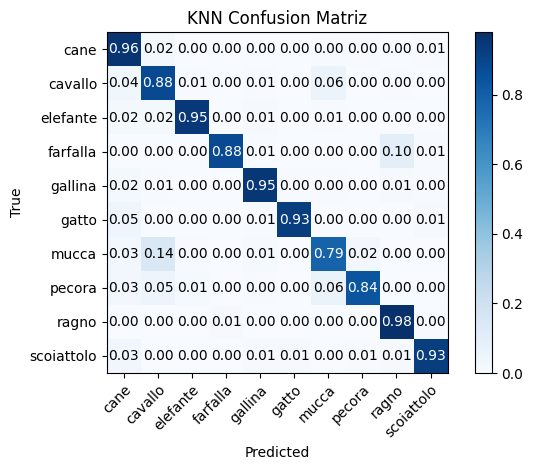

In [31]:
metrics = MetricsAnaliser()
classifiers = ["SVM", "RF", "KNN"]

for pred_index in range(len(results_pred)):
    print(f"\nResults in {classifiers[pred_index]}: \n")
    metrics.plot_confusion_matrix(test_label,
                                  results_pred[pred_index],
                                  classes_names,
                                  title=f"{classifiers[pred_index]} Confusion Matriz",
                                  save_as=f"{classifiers[pred_index]}.png")